# Experiments: "Cloudy" singapore sounding

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we perform the same tests using the Singapore sounding, but with its dew point data replaced by the temperature data to make it uniformly saturated (not a significant change since the relative humidity is already close to 100%) and add 0.5 g/kg liquid water everywhere to give a first approximation of a cloudy environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from pint import set_application_registry
set_application_registry(units)

from scipy.integrate import simps

import sys
from os import mkdir
from os.path import exists
import shelve

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, saturation_specific_humidity
from thermo import temperature_change
from entraining_parcel import EntrainingParcel

In [3]:
fig_path = (
    '/Users/tschanzer/OneDrive - UNSW/UNSW2021/T3/ToR/taste-of-research-21T3/'
    'notebooks/20211027_experiments_singapore_cloudy/figures/')
if not exists(fig_path):
    mkdir(fig_path)

In [9]:
file = '../../soundings/48698 WSSS Singapore Observations at 00Z 02 Sep 2021.txt'
sounding = pd.read_fwf(
    file, names=['pressure', 'height', 'temperature'],
    usecols=[0, 1, 2], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
liquid_ratio = np.ones(temperature.size)*0.5e-3*units.dimensionless
singapore = Environment(
    pressure, height, temperature, temperature, liquid_ratio,
    info='48698 WSSS Singapore Observations at 00Z 02 Sep 2021',
    name='Singapore (Cloudy)')

In [10]:
parcel = EntrainingParcel(singapore)

# Entrainment rate vs. dependent variables

We first fix the initial conditions and vary the entrainment rate. We use an environmental parcel from the Singapore sounding at $z=5$ km that has become saturated by precipitation.

## Height and velocity

In [6]:
singapore.height(520*units.mbar)

5539.317073170731 <Unit('meter')>

In [11]:
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = singapore.pressure(z_initial)
t_initial = singapore.wetbulb_temperature(z_initial)
q_initial = saturation_specific_humidity(p_initial, t_initial)
time = np.arange(0, 10.1, 0.1)*units.minute

rates = np.arange(0, 2.1, 0.5)/units.km

In [20]:
%%time
l_initial = 2e-3*units.dimensionless
sols = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, rates.size))
    sol = parcel.motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate)
    sols.append(sol)
sys.stdout.write('\n')

Calculation 5 of 5
CPU times: user 25.3 s, sys: 189 ms, total: 25.5 s
Wall time: 26 s


In [14]:
with shelve.open('moist_motion_vs_entrainment_rate') as file:
    file['parcel'] = parcel
    file['z_initial'] = z_initial
    file['w_initial'] = w_initial
    file['t_initial'] = t_initial
    file['q_initial'] = q_initial
    file['l_initial'] = l_initial
    file['time'] = time
    file['rates'] = rates
    file['sols'] = sols
    print([x for x in file.keys()])

['w_initial', 'sols', 'q_initial', 'z_initial', 'time', 'rates', 'parcel', 't_initial', 'l_initial']


In [42]:
with shelve.open('moist_motion_vs_entrainment_rate') as file:
    sols = file['sols']

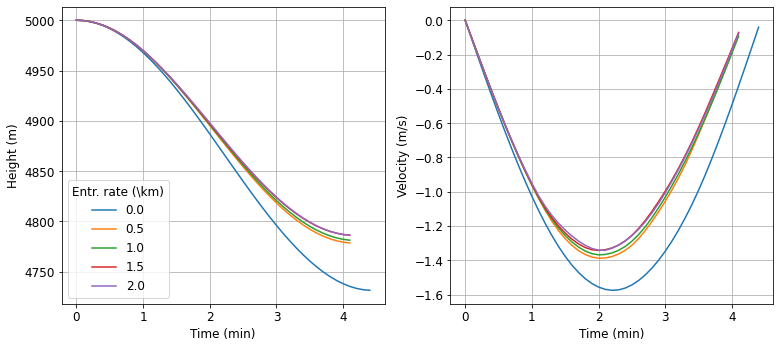

In [43]:
# simple height/velocity plot
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols):
    ax1.plot(time, sol.height, label=str(rates[i].m))
    ax2.plot(time, sol.velocity)

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
lgd = ax1.legend(loc='lower left')
lgd.set_title('Entr. rate (\km)')
ax1.grid()
ax2.grid()

fig.tight_layout()
fig.savefig(
    fig_path + 'entrainment_rate_vs_motion.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: since the environment here is saturated, the parcel cannot be initially cooled by precipitation and all negative buoyancy is initially due to the weight of liquid water. Although entrainment does bring the parcel into equilibrium with its environment sooner, the effect is less pronounced than in the Sydney sounding because the parcels are almost neutrally buoyant to start with.

## Maximum/height-averaged velocity and mass flux

In [22]:
for sol in sols:
    z = sol.height[~np.isnan(sol.height)].m
    v = sol.velocity[~np.isnan(sol.velocity)].m
    massflux = sol.massflux[~np.isnan(sol.massflux)].m
    
    sol.velocity_zavg = 1/(z[-1] - z[0])*simps(v, z)*sol.velocity.units
    sol.massflux_zavg = 1/(z[-1] - z[0])*simps(massflux, z)*sol.massflux.units

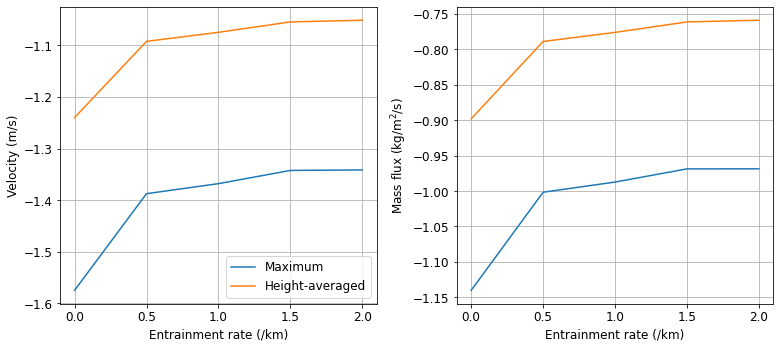

In [23]:
# maximum velocity and mass flux
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rates, [np.nanmin(sol.velocity.m) for sol in sols], label='Maximum')
ax1.plot(rates, [sol.velocity_zavg.m for sol in sols], label='Height-averaged')
ax1.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax1.legend()

ax2.plot(rates, [np.nanmin(sol.massflux.m) for sol in sols], label='2')
ax2.plot(rates, [sol.massflux_zavg.m for sol in sols])
ax2.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Mass flux (kg/m$^2$/s)')
ax2.grid()

fig.tight_layout()
fig.savefig(
    fig_path + 'entrainment_rate_vs_velocity.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for the Sydney sounding.

# Initial condition vs. dependent variables

We now fix the entrainment rate at 1/km and vary the amount of liquid water initially added to the parcel by precipitation.

In [34]:
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = singapore.pressure(z_initial)

l_initial = np.linspace(0, 2e-3, 11)[1:]*units.dimensionless
t_initial = np.ones(l_initial.size)*singapore.temperature(z_initial)
q_initial = np.ones(l_initial.size)*singapore.specific_humidity(z_initial)

time = np.arange(0, 10.1, 0.1)*units.minute
rate = 1/units.km

In [29]:
%%time
sols = []
i = 0
for t, q, l in zip(t_initial, q_initial, l_initial):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, t_initial.size))
    sol = parcel.motion(time, z_initial, w_initial, t, q, l, rate)
    sols.append(sol)
    i += 1
sys.stdout.write('\n')

Calculation 10 of 10
CPU times: user 33.4 s, sys: 211 ms, total: 33.6 s
Wall time: 33.8 s


In [31]:
with shelve.open('motion_vs_initial_conditions') as file:
    file['parcel'] = parcel
    file['z_initial'] = z_initial
    file['w_initial'] = w_initial
    file['t_initial'] = t_initial
    file['q_initial'] = q_initial
    file['l_initial'] = l_initial
    file['time'] = time
    file['rate'] = rate
    file['sols'] = sols
    print([x for x in file.keys()])

['w_initial', 'sols', 'q_initial', 'z_initial', 'time', 'parcel', 'rate', 't_initial', 'l_initial']


In [193]:
with shelve.open('motion_vs_initial_conditions') as file:
    sols = file['sols']

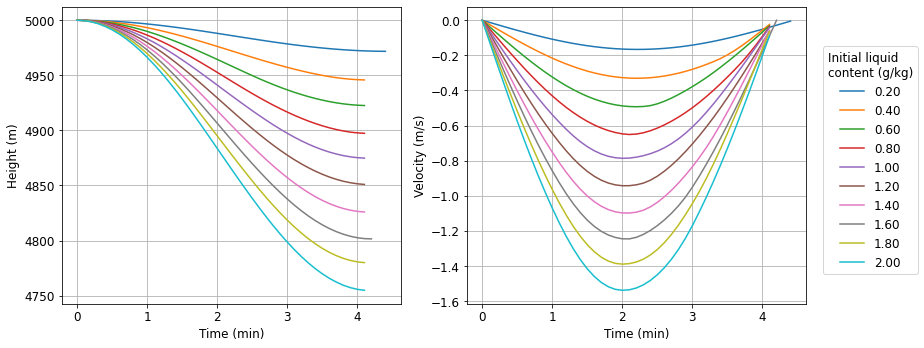

In [38]:
# simple height/velocity plot
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols):
    ax1.plot(time, sol.height)
    ax2.plot(time, sol.velocity, label='{:.2f}'.format(l_initial[i].m*1e3))

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax2.grid()
lgd = ax2.legend(loc=(1.05, 0.1))
lgd.set_title('Initial liquid\ncontent (g/kg)')

fig.tight_layout()
fig.savefig(
    fig_path + 'initial_conditions_vs_motion.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for Sydney. The greater the amount of water initially added to the parcel, the further and the faster it descends.

In [39]:
for sol in sols:
    z = sol.height[~np.isnan(sol.height)].m
    v = sol.velocity[~np.isnan(sol.velocity)].m
    massflux = sol.massflux[~np.isnan(sol.massflux)].m
    
    sol.velocity_zavg = 1/(z[-1] - z[0])*simps(v, z)*sol.velocity.units
    sol.massflux_zavg = 1/(z[-1] - z[0])*simps(massflux, z)*sol.massflux.units

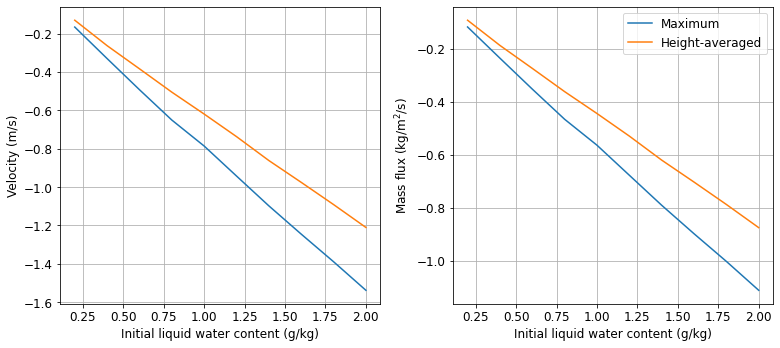

In [41]:
# maximum velocity and mass flux
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(l_initial.m*1e3, [np.nanmin(sol.velocity.m) for sol in sols])
ax1.plot(l_initial.m*1e3, [sol.velocity_zavg.m for sol in sols])
ax2.plot(l_initial.m*1e3, [np.nanmin(sol.massflux.m) for sol in sols],
         label='Maximum')
ax2.plot(l_initial.m*1e3, [sol.massflux_zavg.m for sol in sols],
         label='Height-averaged')

ax1.set(
    xlabel='Initial liquid water content (g/kg)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax2.set(
    xlabel='Initial liquid water content (g/kg)',
    ylabel='Mass flux (kg/m$^2$/s)')
ax2.grid()
ax2.legend()

fig.tight_layout()
fig.savefig(
    fig_path + 'initial_conditions_vs_velocity.png', dpi=300, facecolor='w',
    bbox_inches='tight')

Conclusion: as for Sydney. Adding more water to a parcel initially produces a stronger downdraft. The relationship is almost perfectly linear.